In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from scipy.spatial.distance import cdist

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<br>

## $\textrm{Data}$

<br>

$ \textbf{HWCDW} \ \textrm{Nominal compensation per employee: total economy (HWCDW) - 1000CU }$

$ \textbf{NLTN} \ \textrm{Total labour force (Labour force statistics) (NLTN) - 1000 persons }$

$ \textbf{OKND} \ \textrm{Net capital stock at 2010 prices: total economy (OKND) - Mrd CU }$

$ \textbf{OVGD} \ \textrm{Gross domestic product at 2010 reference levels (OVGD) - Mrd CU }$

$ \textbf{UVGE} \ \textrm{Gross value added at current basic prices excluding FISIM: total economy (UVGE) - Mrd CU }$

$ \textbf{ZUTN} \ \textrm{Unemployment rate: total :- Member States: definition EUROSTAT (ZUTN) - (Percentage of active population)  }$

$ \textbf{USGN} \ \textrm{Gross national saving (USGN) - Mrd CU  }$

<br>

In [7]:
def data_handling(data_source, study_countries):
    study_indicators = list(set(data_source.Indicator))
    study_years = [i for i in range(1960, 2020)]
    
    counter = 0
    col = ["country", "year"]; col.extend(study_indicators)
    output = pd.DataFrame(index=col)
        
    for country in study_countries:
        for year in study_years:
            counter += 1
            indicators = [data_source[(data_source.Country == country) & (data_source.Indicator == indicator)][str(year)].values[0] for indicator in study_indicators]
            row_values = [country, int(year)]; row_values.extend(indicators)
            output[counter] = row_values
    
    output_corrected = output.transpose().copy()
    output_corrected.HWCDW *= 1000
    output_corrected.NLTN *= 1000
    output_corrected.OKND *= 10**9
    output_corrected.OVGD *= 10**9
    output_corrected.UVGE *= 10**9
    output_corrected.ZUTN /= 100
    output_corrected.USGN *= 10**9
    
    return(output_corrected)

In [8]:
study_countries = ["Austria", "Belgium", "Cyprus", "Estonia", "Finland", "France", "Germany", 
                   "Greece", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", 
                   "Netherlands", "Portugal", "Slovakia", "Slovenia", "Spain"]

In [9]:
source = pd.read_csv("./data_source.csv")
data = data_handling(source, study_countries)

<br>

## $\textrm{Statistical}$

In [10]:
def statistical(data_input, study_countries):
    data_input=data_input[data_input.year >= 1997]
    
    study_years = [i for i in range(1997, 2020)]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    for country in study_countries:
        country_series = data_input[data_input.country == country].OVGD.values
        cycle, trend = sm.tsa.filters.hpfilter(country_series, 1600)
        
        output_trend[country] = trend
        output_cycle[country] = cycle
            
    gap = output_cycle.dropna(axis=1).astype(float); gap.index = pd.to_datetime(gap.index, format='%Y')
    potential = output_trend.dropna(axis=1).astype(float); potential.index = pd.to_datetime(potential.index, format='%Y')
            
    return(potential+gap, potential, gap)

In [11]:
statistical_gdp, statistical_potential, statistical_gap = statistical(data, study_countries)

<br>

In [12]:
def graphs_potential(input_gdp, input_potential, input_gap, input_type):
      
    plt.figure()
    (input_potential/input_potential.iloc[0]*100).plot(figsize=(20, 10), colormap="tab20")
    plt.title(input_type + " Approach: Potential GDP of EU Countries", fontsize=20)
    plt.ylabel("Potential GDP")
    plt.xlabel("Date, Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.figure()
    (input_gap/input_gdp*100).plot(figsize=(20, 10), colormap="tab20")
    plt.title(input_type+" Approach: GDP Gaps of EU Countries", fontsize=20)
    plt.ylabel("GDP Gap, \%")
    plt.xlabel("Date, Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

<Figure size 432x288 with 0 Axes>

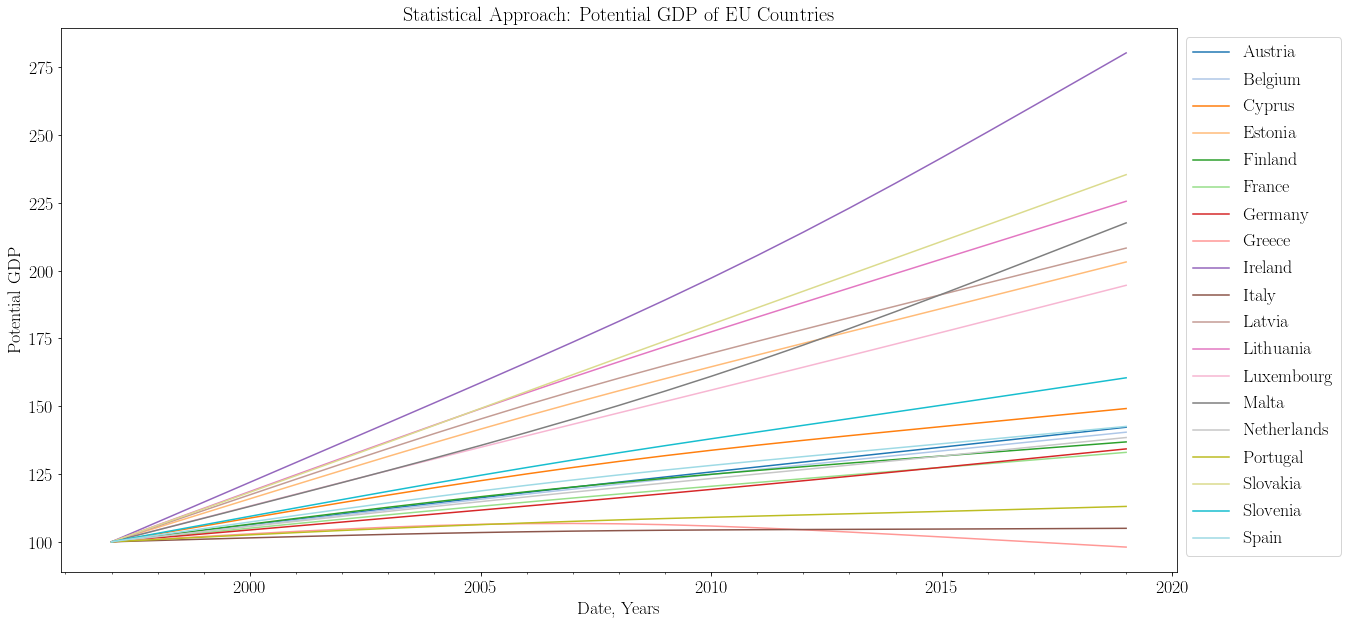

<Figure size 432x288 with 0 Axes>

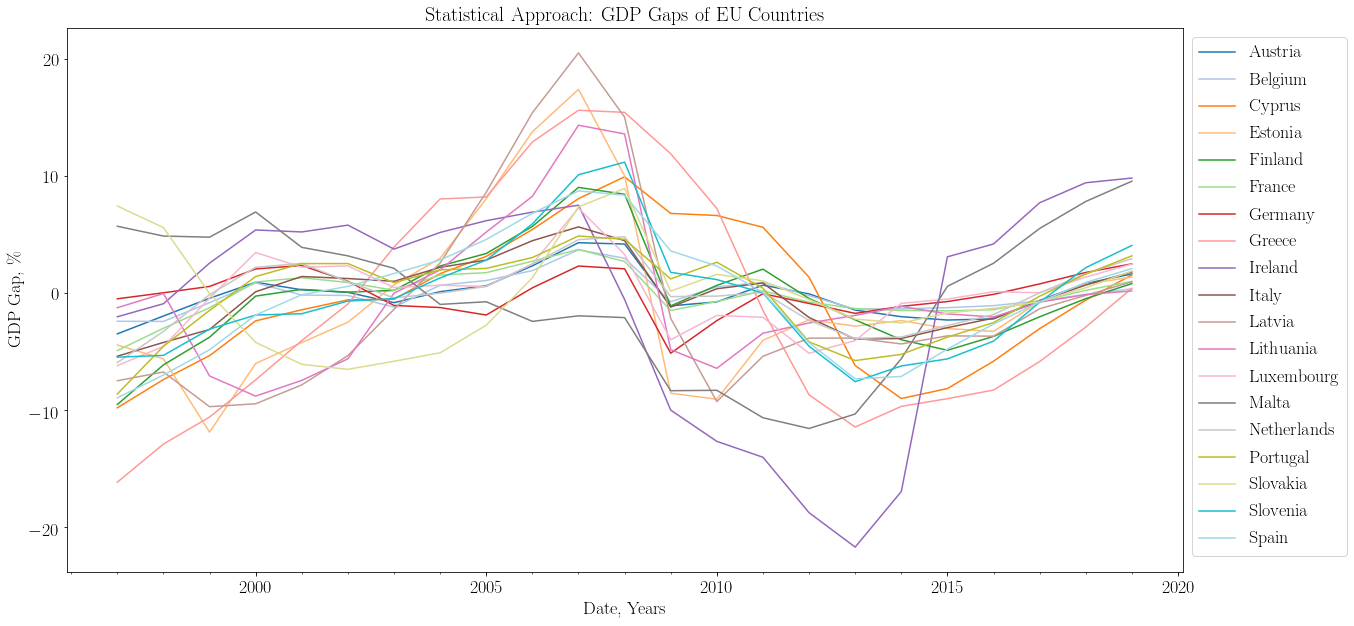

In [13]:
graphs_potential(statistical_gdp, statistical_potential, statistical_gap, "Statistical")

<br>

## $\textrm{Structural}$

In [14]:
def structural(data_input, study_countries):

    study_years = [i for i in range(1997, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    output_trend = pd.DataFrame(index=study_years)
    output_cycle = output_trend.copy()
    
    data_input=data_input[data_input.year >= 1997]
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.set_index("year")

        # Calculate α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        
        # Calculate TFP
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
        
        # Calculate natural rate of unemployment
        _, country_indicators["NRU"] = sm.tsa.filters.hpfilter(country_indicators["ZUTN"].values, 1600)
        
        # Calculate trend and gap
        output_trend[country] = country_indicators["TFP"]*(country_indicators["OKND"].pow(country_indicators["α"])*
                                                           (country_indicators["NLTN"]*(-country_indicators["NRU"]+1)).pow(-country_indicators["α"]+1))
        
        output_cycle[country] = country_indicators["OVGD"]-output_trend[country]
        
    gap = output_cycle.dropna(axis=1).astype(float); gap.index = pd.to_datetime(gap.index, format='%Y')
    potential = output_trend.dropna(axis=1).astype(float); potential.index = pd.to_datetime(potential.index, format='%Y')
            
    return(potential+gap, potential, gap)

In [15]:
structural_gdp, structural_potential, structural_gap = structural(data, study_countries)

<br>

<Figure size 432x288 with 0 Axes>

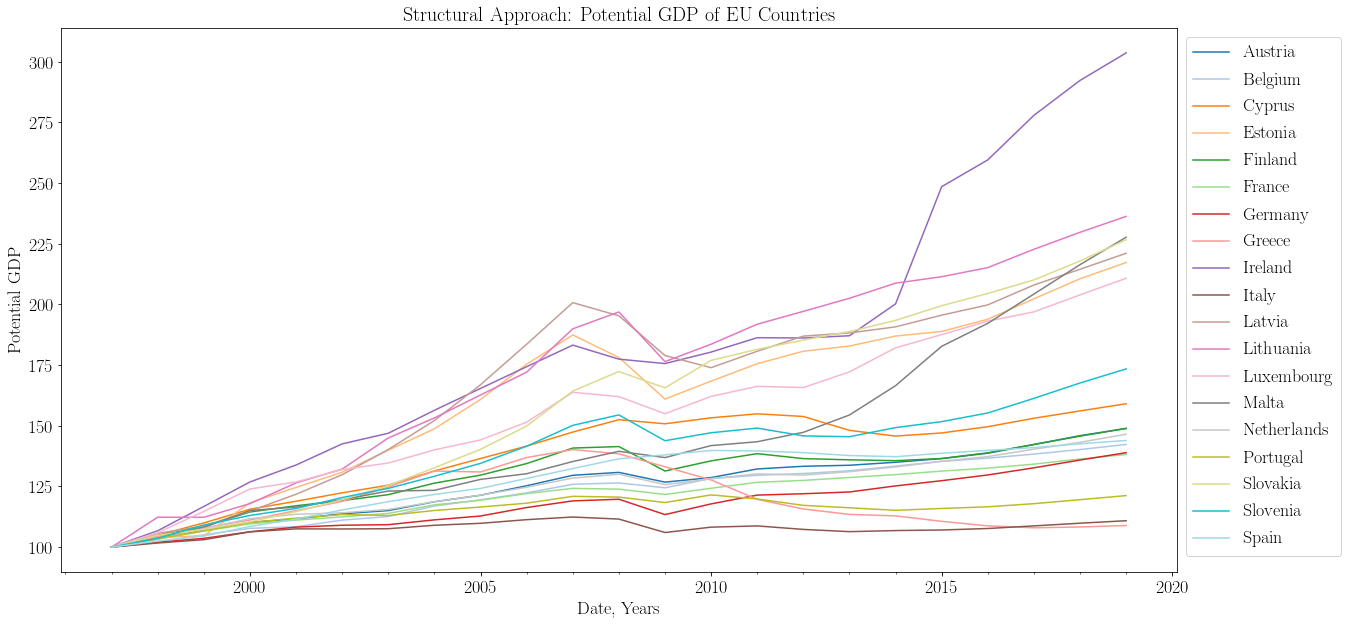

<Figure size 432x288 with 0 Axes>

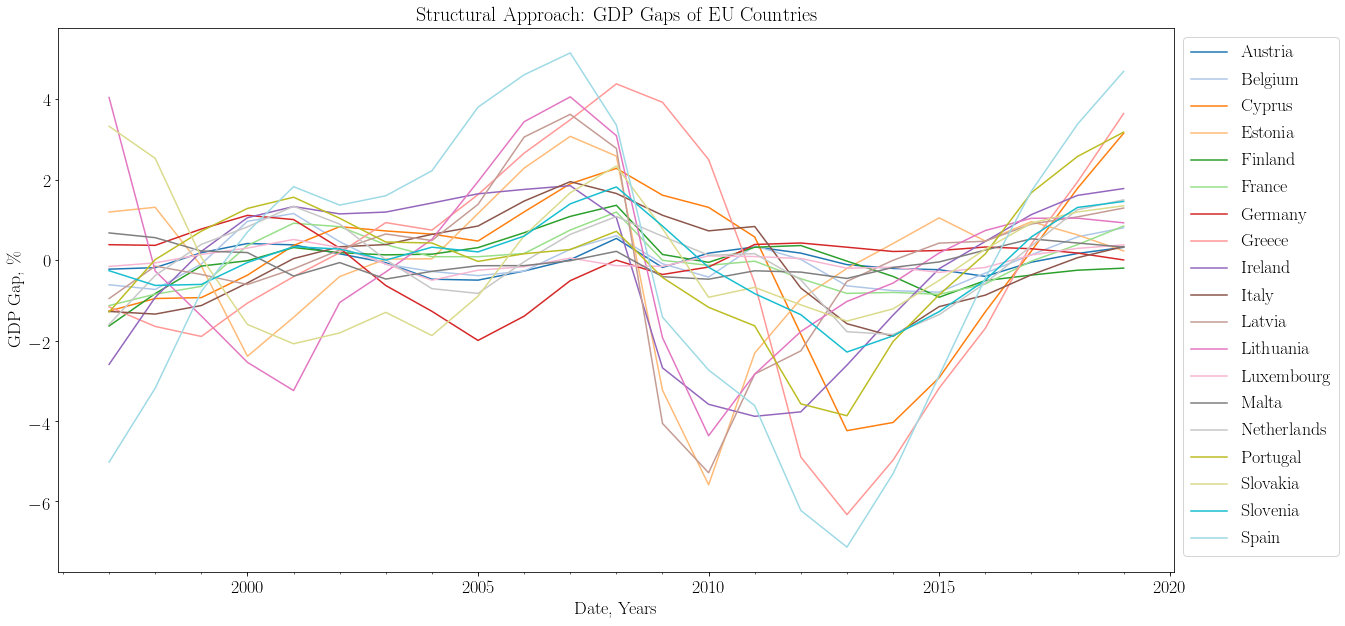

In [16]:
graphs_potential(structural_gdp, structural_potential, structural_gap, "Structural")

<br>

_______

# $\textrm{Clustering and Correlations}$

In [17]:
def k_elbow(stat_gap, stat_gdp, stru_gap, stru_gdp):
    
    f, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True)
    
    data_kmeans = (stat_gap/stat_gdp).T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    res = list()
    n_cluster = range(2,15)
    for n in n_cluster:
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit(X)
        res.append(np.average(np.min( cdist(X.reshape(shape), km.cluster_centers_.reshape((n, shape[1]))), axis=1)))
           
    axes[0].plot(n_cluster, res)
    axes[0].set_title("Statistical: Elbow Curve Method", fontsize=20)
    axes[0].set_ylabel("Distortion")
    axes[0].set_xlabel("Number of Country Clusters")
    
    
    data_kmeans = (stru_gap/stru_gdp).T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    res = list()
    n_cluster = range(2,15)
    for n in n_cluster:
        km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit(X)
        res.append(np.average(np.min( cdist(X.reshape(shape), km.cluster_centers_.reshape((n, shape[1]))), axis=1)))
          
    axes[1].plot(n_cluster, res)
    axes[1].set_title("Structural: Elbow Curve Method", fontsize=20)
    axes[1].set_ylabel("Distortion")
    axes[1].set_xlabel("Number of Country Clusters")

    plt.tight_layout()

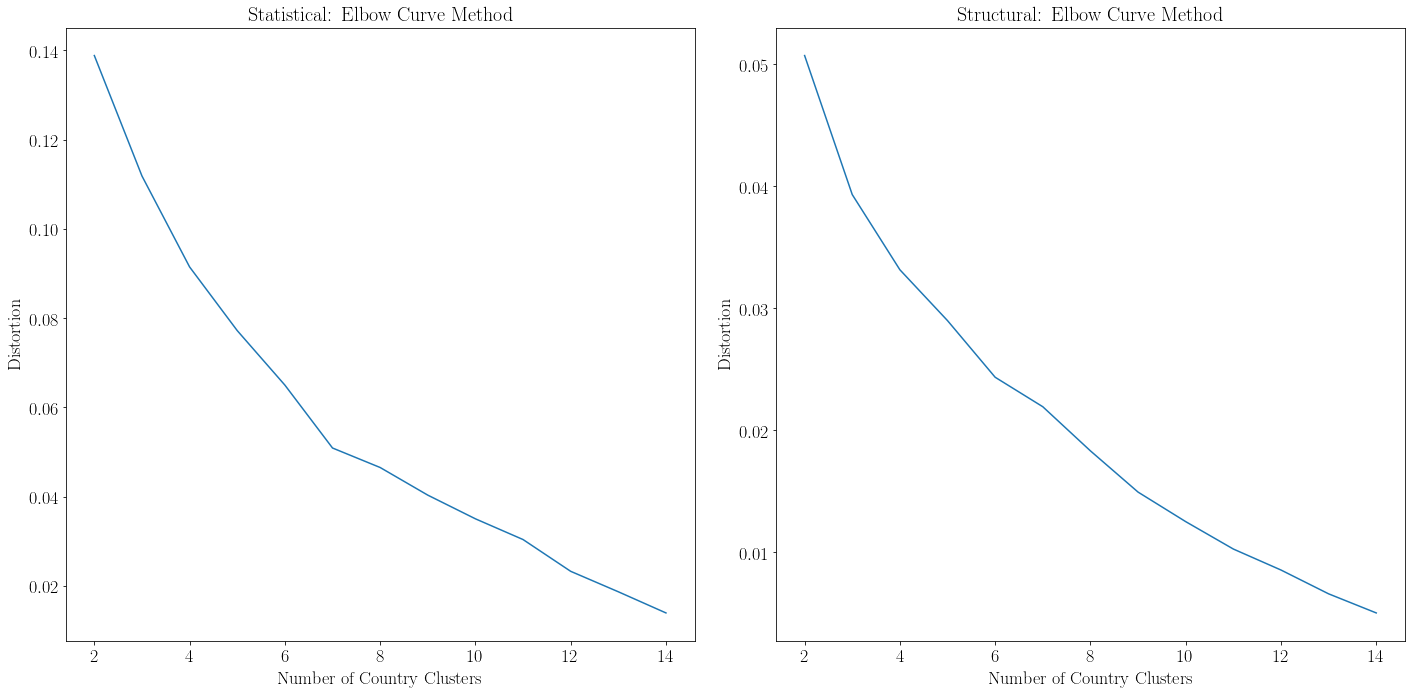

In [18]:
k_elbow(statistical_gap, statistical_gdp, structural_gap, structural_gdp)

<br>

In [19]:
def countries_k(gap, gdp, n):
    
    data_kmeans = (gap/gdp).T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit_predict(X)
    
    return(km)

In [20]:
def corrs_potential(sta_gap, stru_gap, sta_gdp, stru_gdp):
    
    n = 4
    clusters_table = pd.DataFrame(np.array([countries_k(stru_gap, stru_gdp, n), countries_k(sta_gap, sta_gdp, n)]).T, 
                                  index=stru_gap.columns, columns=["Structural", "Statistical"])
    sta_order = clusters_table.sort_values("Statistical").Statistical.index.values
    stru_order = clusters_table.sort_values("Structural").Structural.index.values
    
    f, axes = plt.subplots(1, 2, figsize=(24, 10), sharex=True)
    
    sns.heatmap(sta_gap[sta_order].corr(), mask=np.zeros_like(sta_gap[sta_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True, ax=axes[0]).set_title("Statistical", fontsize=30)
    
    sns.heatmap(stru_gap[stru_order].corr(), mask=np.zeros_like(stru_gap[stru_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True, ax=axes[1]).set_title("Structural", fontsize=30)
    
    plt.tight_layout()

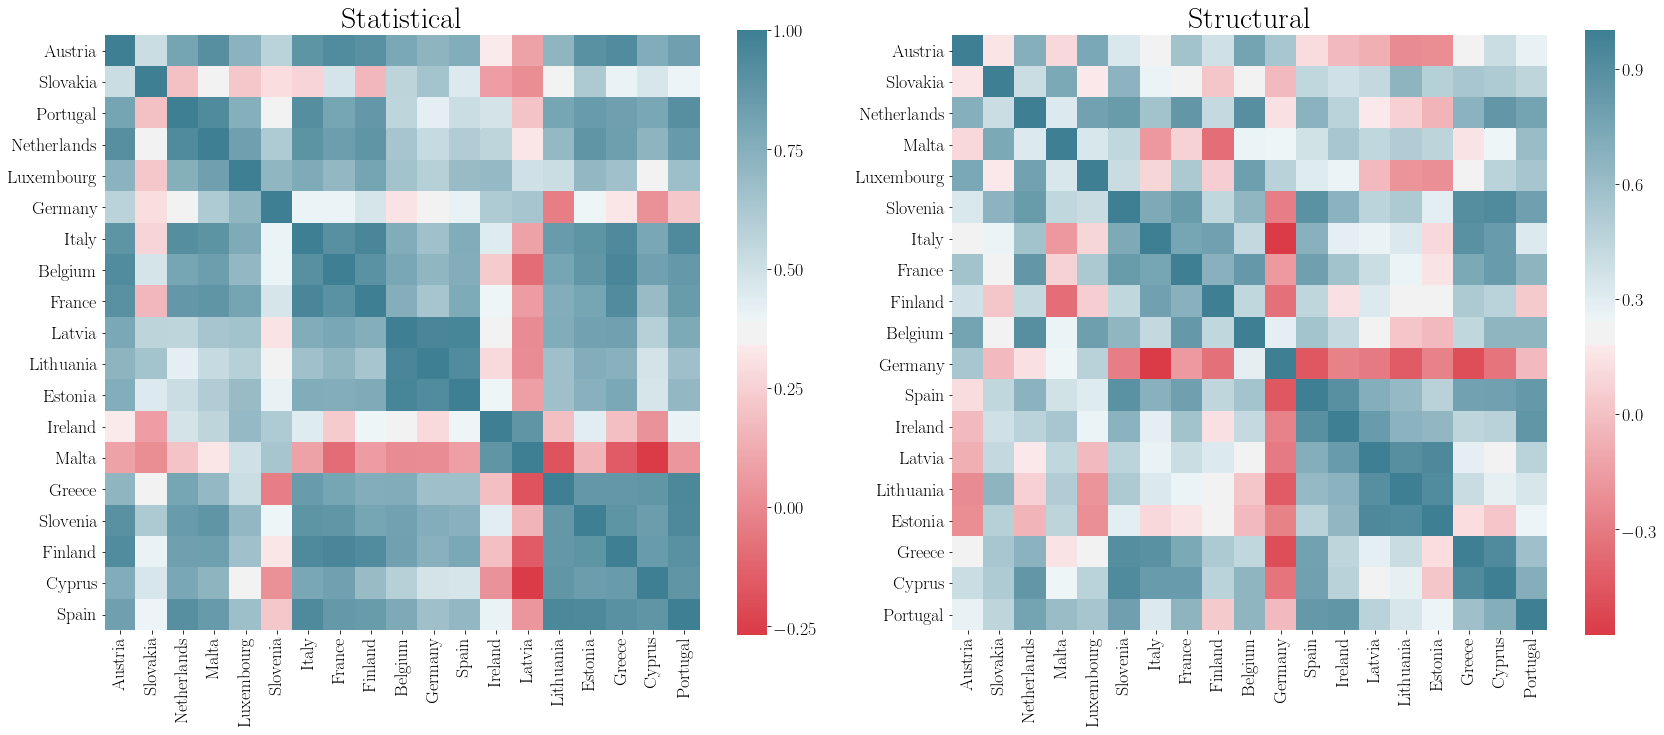

In [21]:
corrs_potential(statistical_gap, structural_gap, statistical_gdp, structural_gdp)

<br>

____________

# $\textrm{Growth Decomposition}$

In [22]:
def growth_decomposition(data_input, study_countries):

    study_years = [i for i in range(1997, 2020)]
    study_indicators = ["year", "HWCDW", "NLTN", "OKND", "OVGD", "UVGE", "ZUTN"]
    
    data_input=data_input[data_input.year >= 1997]
    
    ΔGDP = pd.DataFrame(index=study_years[1:]);
    ΔTFP = ΔGDP.copy(); ΔK = ΔGDP.copy(); ΔαK = ΔGDP.copy(); ΔN = ΔGDP.copy(); Δ1αN = ΔGDP.copy(); Δα = ΔGDP.copy()
    
    for country in study_countries:
        
        country_indicators = pd.DataFrame()
        
        for indicator in study_indicators:
            country_indicators[indicator] = data_input[data_input.country == country][indicator]
            
        country_indicators = country_indicators.set_index("year")
        
        # Add ΔGDP
        ΔGDP[country] = country_indicators["OVGD"].pct_change().values[1:]
        
        #Calculate N
        country_indicators["N"] = (-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]
        # Add ΔN 
        ΔN[country] = country_indicators["N"].pct_change().values[1:]
        
        # Add ΔK
        ΔK[country] = country_indicators["OKND"].pct_change().values[1:]
                
        # Calculate α
        country_indicators["α"] = - (country_indicators["HWCDW"]*(-country_indicators["ZUTN"]+1)*country_indicators["NLTN"])/country_indicators["UVGE"]+1
        # Add Δα
        Δα[country] = country_indicators["α"].pct_change().values[1:]
        Δ1αN[country] = ((-country_indicators["α"]+1)*country_indicators["N"]).pct_change().values[1:]
        ΔαK[country] = (country_indicators["α"]*country_indicators["OKND"]).pct_change().values[1:]
        
        # Calculate TFP
        country_indicators["TFP"] = country_indicators["OVGD"]/(country_indicators["OKND"].pow(country_indicators["α"])*
                                                                ((-country_indicators["ZUTN"]+1)*country_indicators["NLTN"]).pow(-country_indicators["α"]+1))
        # Add ΔTFP
        ΔTFP[country] = country_indicators["TFP"].pct_change().values[1:]
                    
    return(ΔGDP*100, ΔTFP*100, ΔK*100, ΔαK*100, ΔN*100, Δ1αN*100, Δα*100)

In [23]:
ΔGDP, ΔTFP, ΔK, ΔαK, ΔN, Δ1αN, Δα = growth_decomposition(data, study_countries)

<br>

In [24]:
def graph_growth(Δ, indicator):
        
    plt.figure()
    Δ.plot(figsize=(20, 10), colormap="tab20")
    plt.title(indicator+" Growth of EU Countries", fontsize=20)
    plt.ylabel(indicator+" Change, \%")
    plt.xlabel("Date, Years")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    n = 4
    data_kmeans = Δ.T
    X = np.array(data_kmeans).reshape(data_kmeans.shape + (1,))
    shape = data_kmeans.shape
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=50, verbose=False, random_state=0).fit_predict(X)
    clusters_table = pd.DataFrame(np.array(km), index=Δ.columns, columns=["Cat"])
    corr_order = clusters_table.sort_values("Cat").Cat.index.values
    
    plt.figure(figsize=(14,10))
    sns.heatmap(Δ[corr_order].corr(), mask=np.zeros_like(Δ[corr_order].corr(), dtype=np.bool), cmap=sns.diverging_palette(10, 220, as_cmap=True), square=True).set_title("Correlation of "+indicator+" Growth of EU Countries", fontsize=30)
    plt.show()

<Figure size 432x288 with 0 Axes>

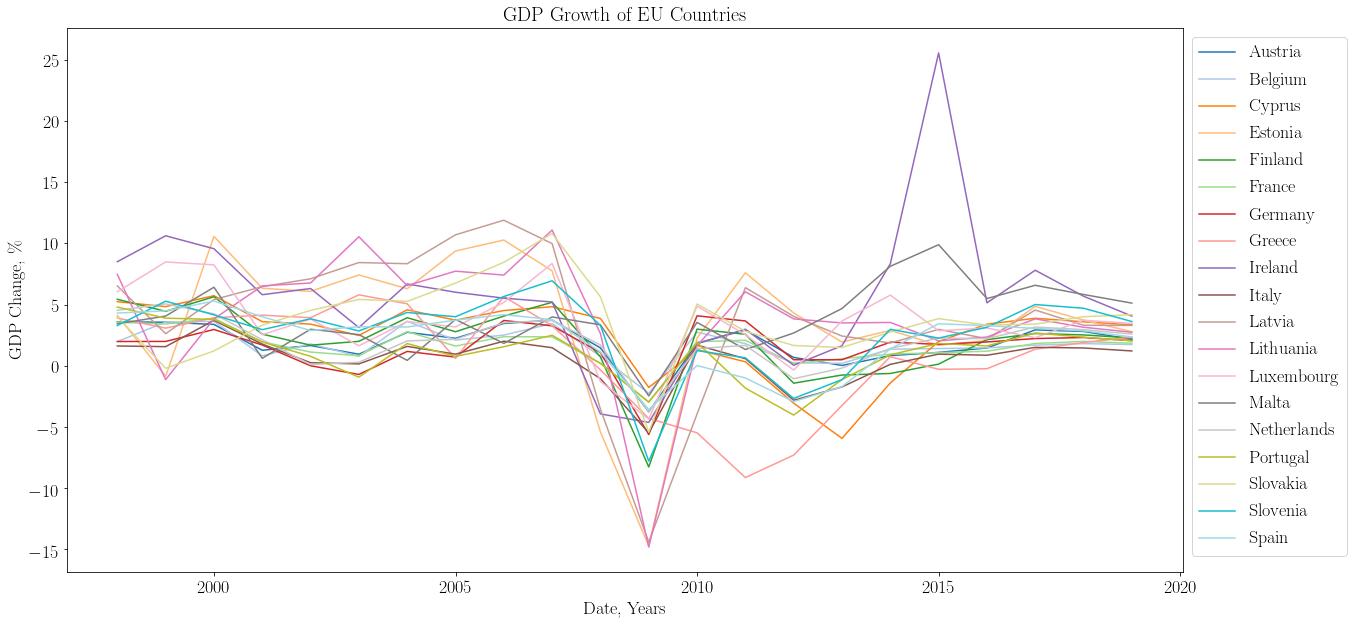

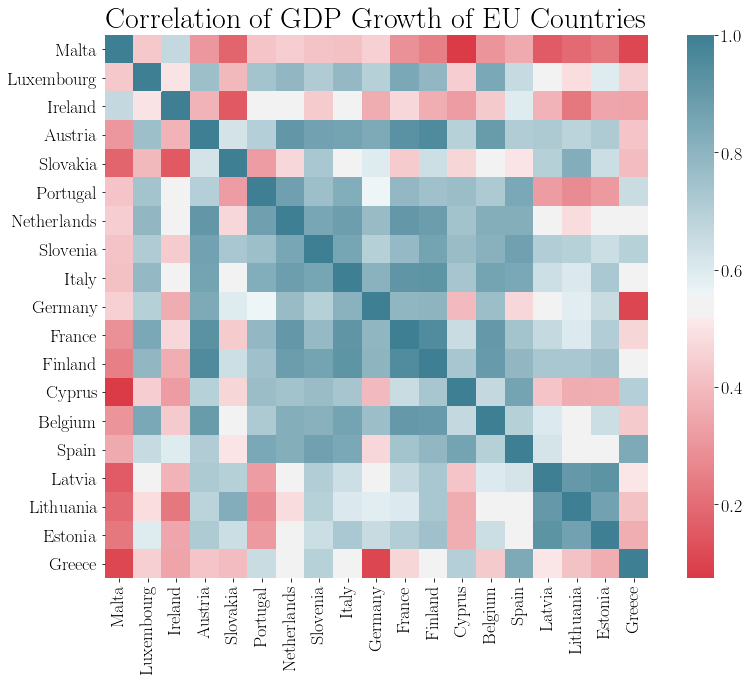

<Figure size 432x288 with 0 Axes>

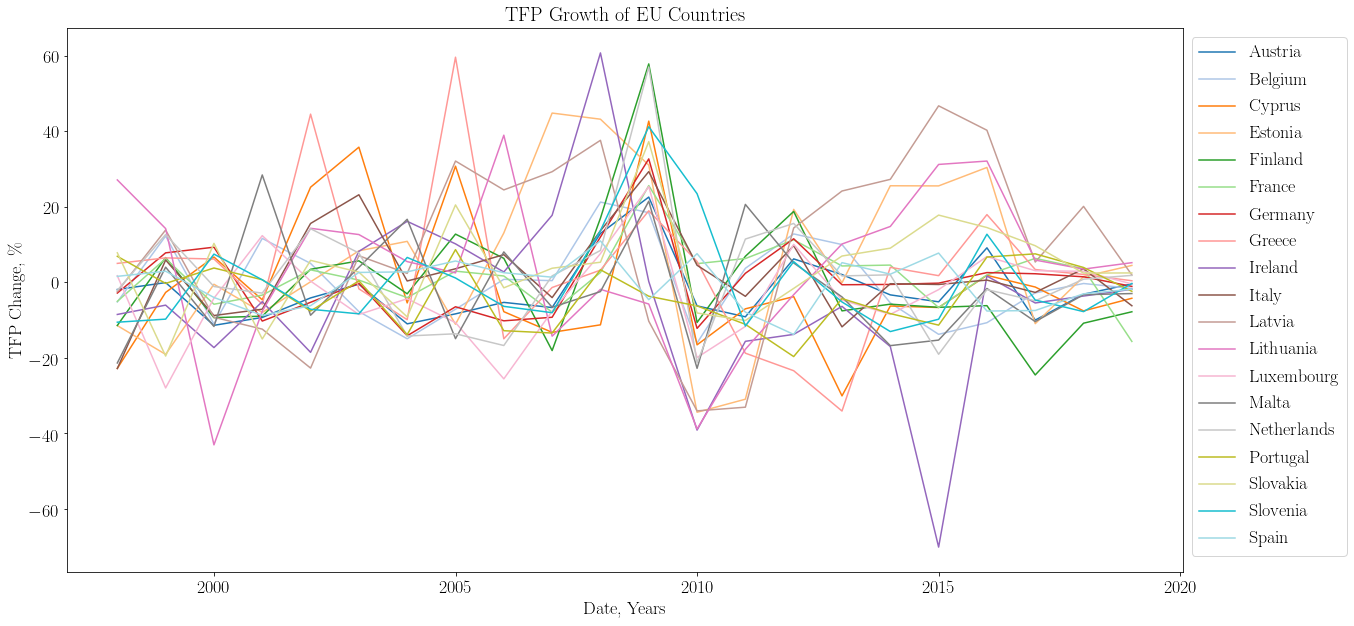

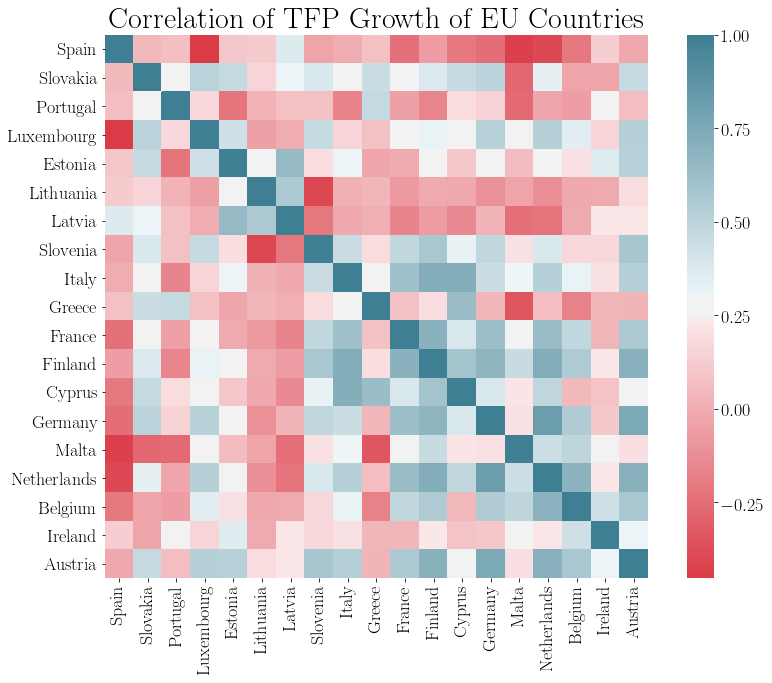

<Figure size 432x288 with 0 Axes>

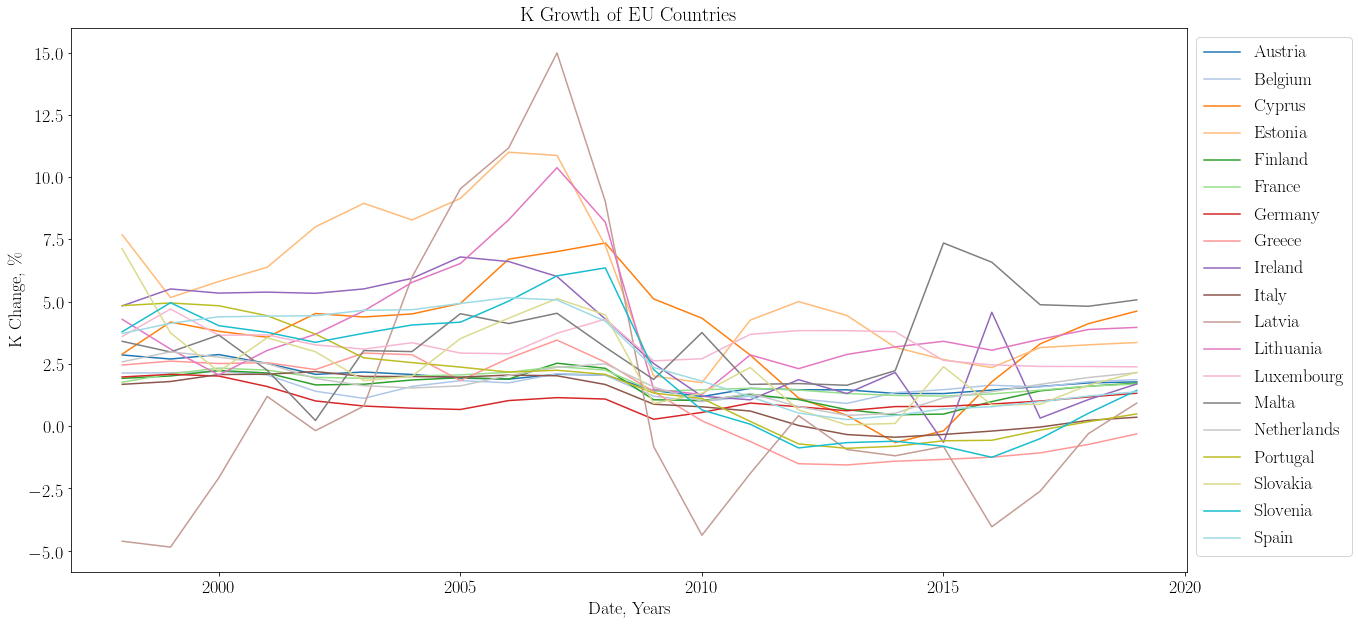

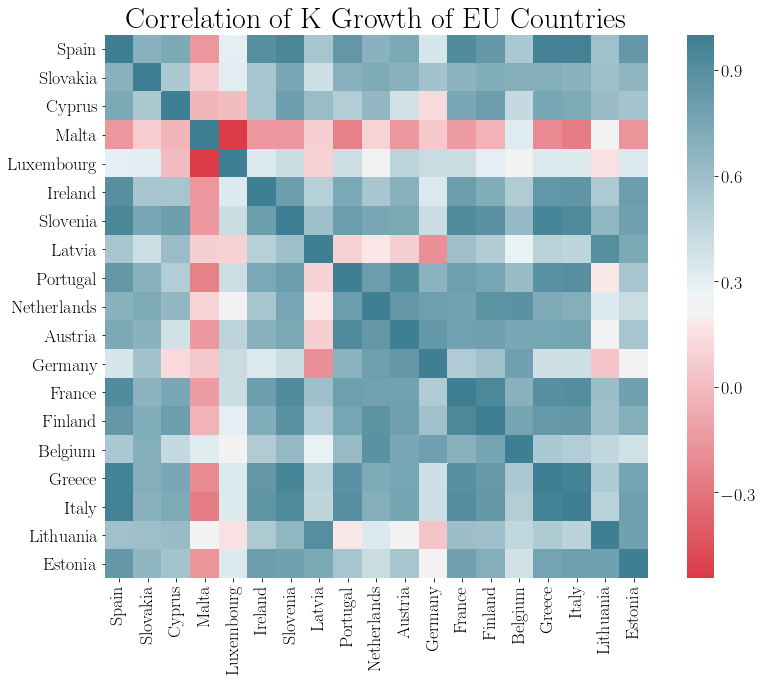

<Figure size 432x288 with 0 Axes>

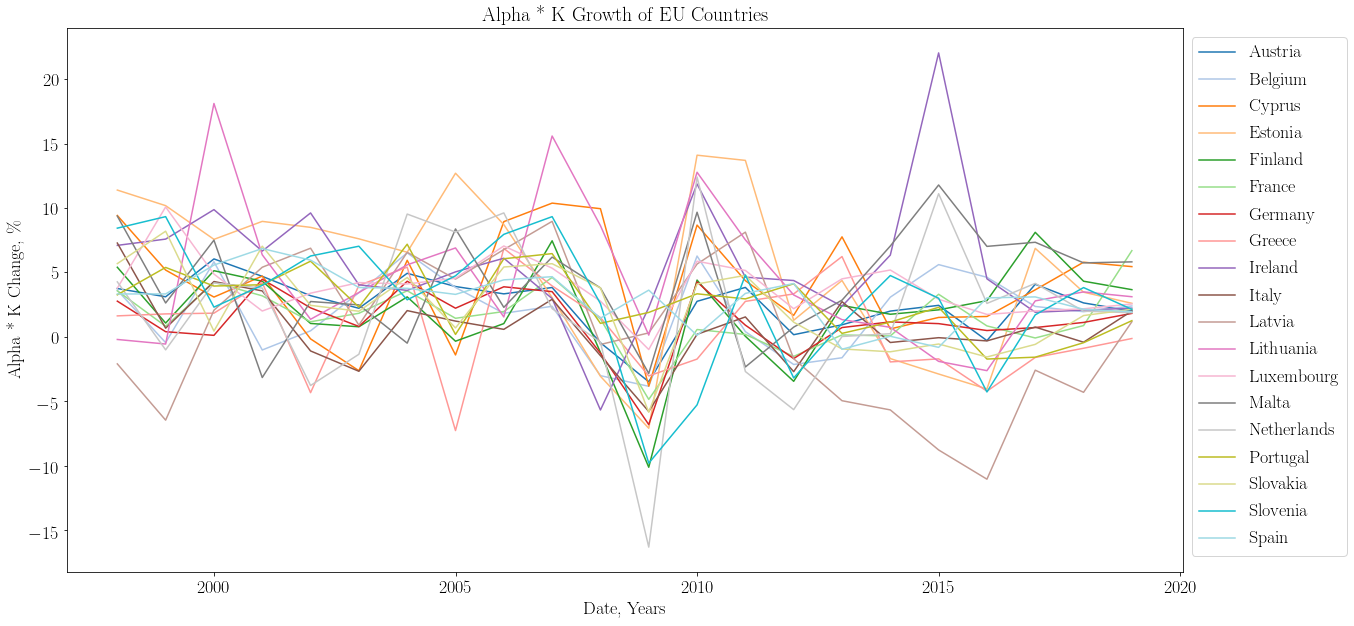

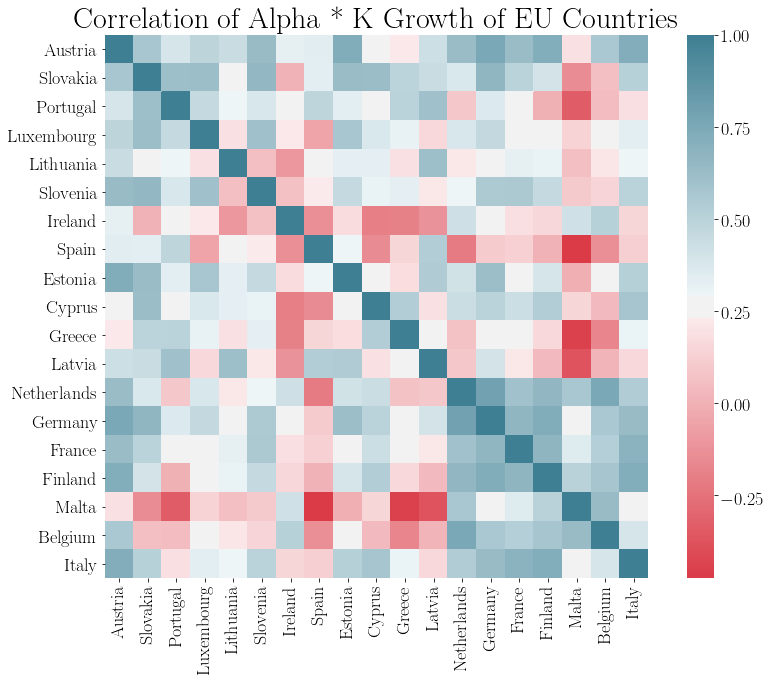

<Figure size 432x288 with 0 Axes>

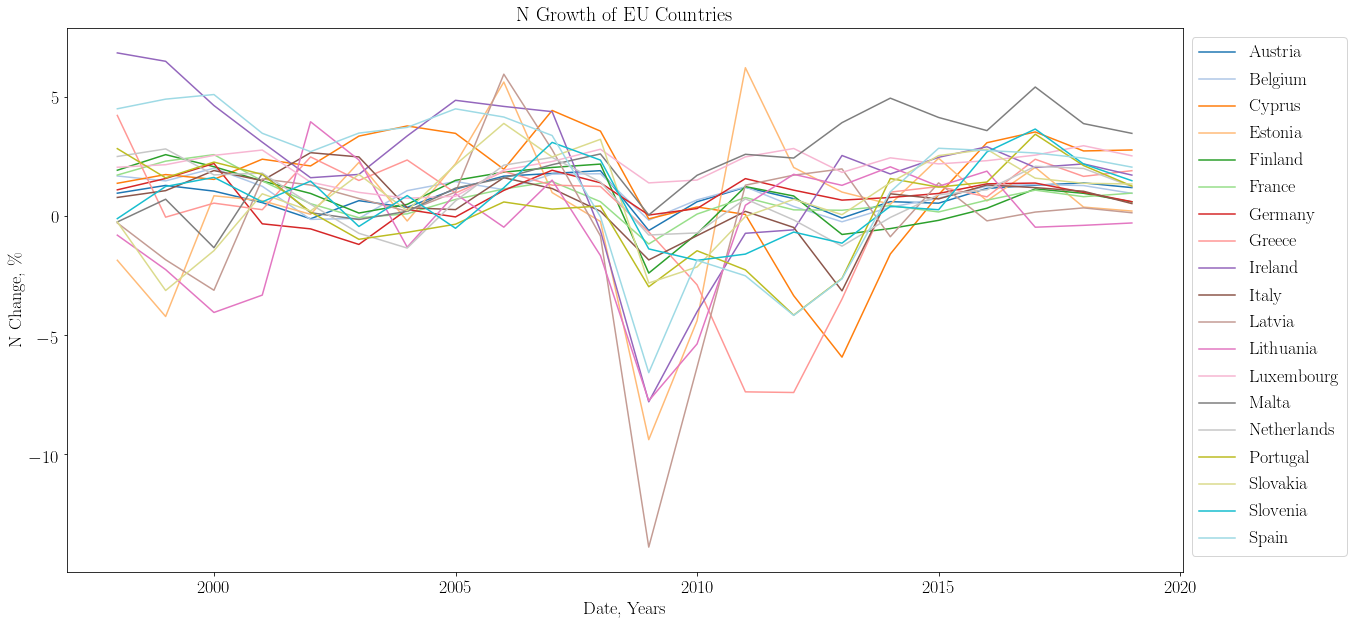

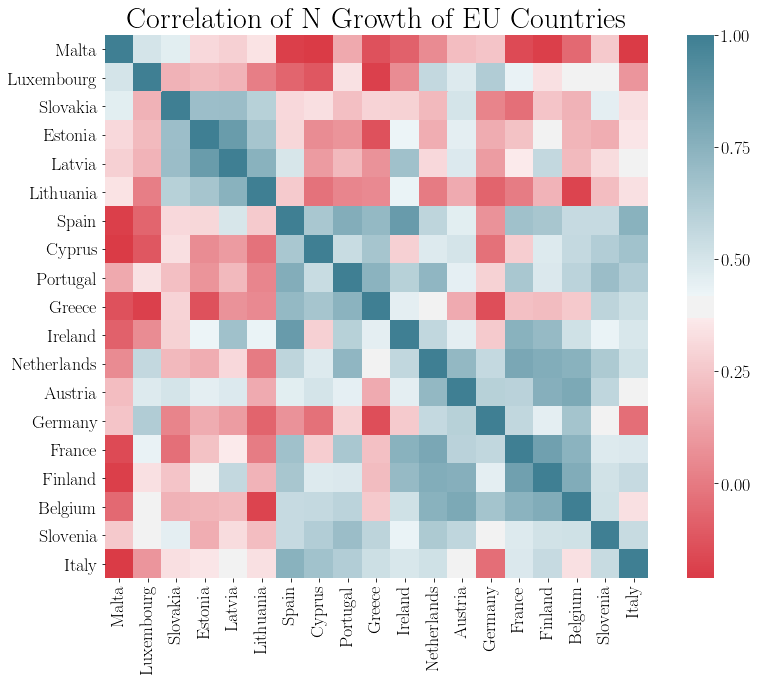

<Figure size 432x288 with 0 Axes>

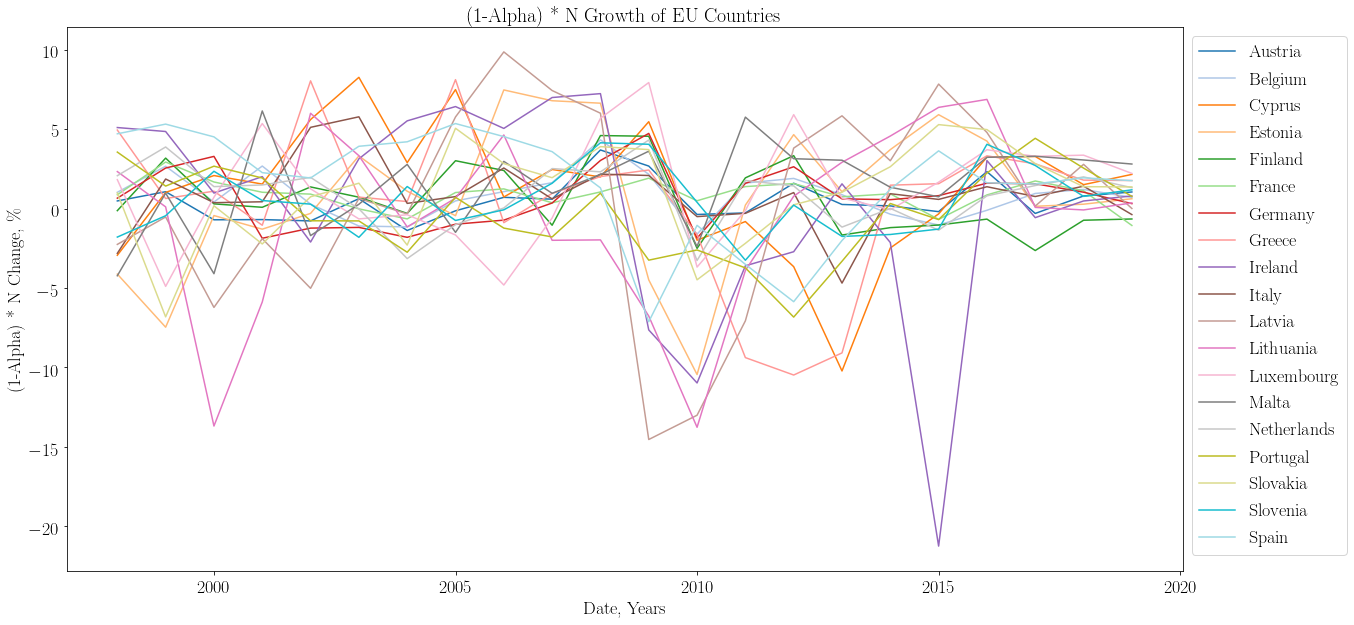

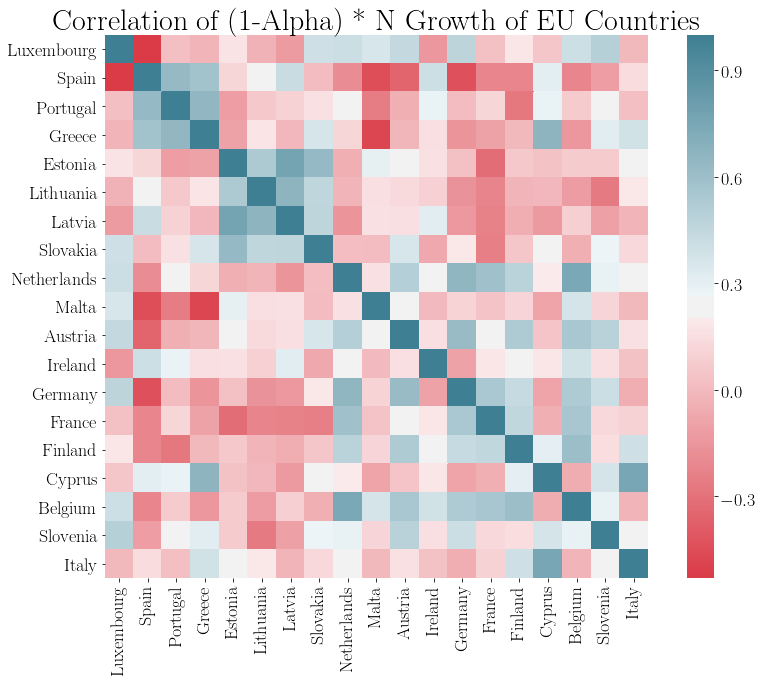

<Figure size 432x288 with 0 Axes>

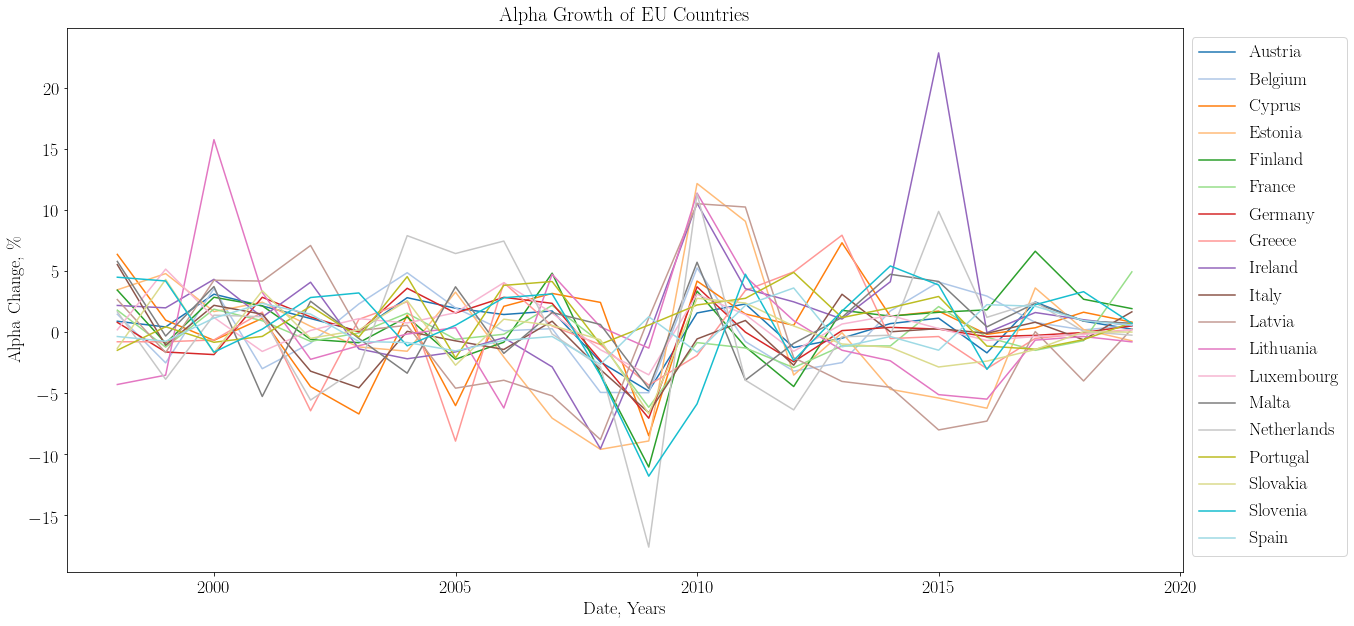

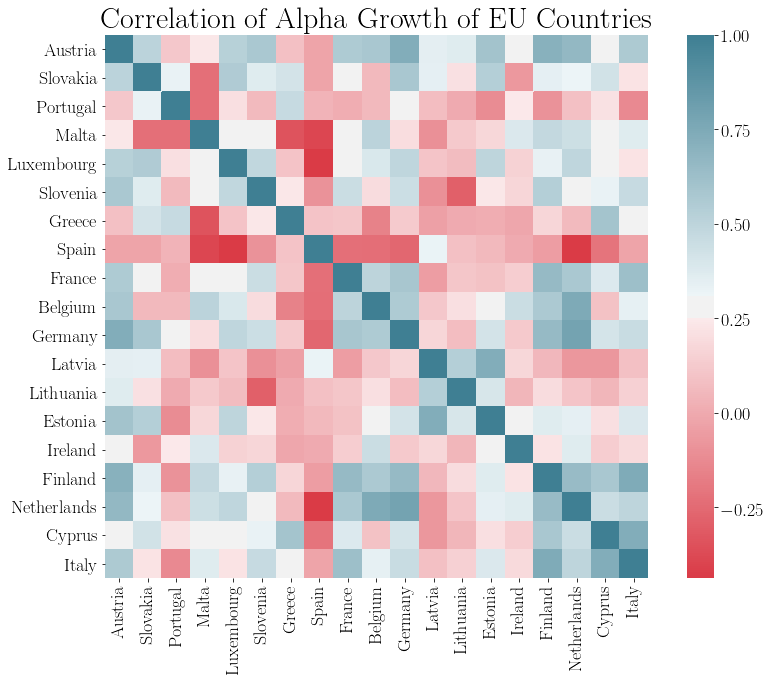

In [25]:
graph_growth(ΔGDP, "GDP")
graph_growth(ΔTFP, "TFP")
graph_growth(ΔK, "K")
graph_growth(ΔαK, "Alpha * K")
graph_growth(ΔN, "N")
graph_growth(Δ1αN, "(1-Alpha) * N")
graph_growth(Δα, "Alpha")

<br>

___________

# $\textrm{Evolution of Efficient Steady States}$

In [28]:
data[data.year >=1997].USGN

38      4.51945e+10
39      4.78494e+10
40      4.83279e+10
41      5.31712e+10
42      5.37452e+10
43      5.89667e+10
44      5.96147e+10
45       6.3457e+10
46      6.52105e+10
47      7.15997e+10
48      8.00467e+10
49      8.43129e+10
50      7.15397e+10
51       7.6436e+10
52      8.09058e+10
53      8.22027e+10
54      8.25458e+10
55      8.65144e+10
56      8.90079e+10
57      9.25613e+10
58      1.00318e+11
59      1.06242e+11
60      1.11533e+11
98      6.07008e+10
99      6.28386e+10
100       6.721e+10
101     7.16336e+10
102     7.10224e+10
103     7.33581e+10
104     7.48858e+10
           ...     
1074    8.21633e+09
1075    9.54542e+09
1076    9.28537e+09
1077    9.70733e+09
1078    1.12519e+10
1079    1.24322e+10
1080    1.31488e+10
1118    1.13927e+11
1119    1.24524e+11
1120    1.33482e+11
1121    1.45123e+11
1122    1.56937e+11
1123    1.73001e+11
1124    1.91858e+11
1125    1.99019e+11
1126    2.08987e+11
1127    2.24746e+11
1128    2.34606e+11
1129    2.27492e+11


In [689]:
def steady_states(data_source):
    

country  year    HWCDW   ZUTN         NLTN         OVGD         OKND  \
38     Austria  1997  29773.4  0.047  3.81373e+06  2.29126e+11  7.85319e+11   
39     Austria  1998  30560.4  0.047  3.85098e+06  2.37332e+11  8.07734e+11   
40     Austria  1999  31149.5  0.042  3.88078e+06  2.45773e+11  8.29472e+11   
41     Austria  2000  31862.3  0.039  3.90978e+06  2.54069e+11  8.53282e+11   
42     Austria  2001  32338.8   0.04  3.93654e+06  2.57289e+11   8.7475e+11   
43     Austria  2002  33014.5  0.044   3.9491e+06  2.61538e+11  8.92905e+11   
44     Austria  2003  33581.1  0.048  3.99193e+06     2.64e+11  9.12267e+11   
45     Austria  2004  34272.7  0.055  4.03683e+06  2.71221e+11  9.31164e+11   
46     Austria  2005  34969.6  0.056  4.08755e+06  2.77307e+11  9.49086e+11   
47     Austria  2006    36046  0.053  4.14357e+06  2.86886e+11  9.66969e+11   
48     Austria  2007  37114.2  0.049  4.20065e+06  2.97579e+11   9.8707e+11   
49     Austria  2008  38337.8  0.041  4.24569e+06  3.01925e+11   1.0073e+12   
50     Austria  2009  38967.7  0.053    4.274e+06  2.90559e+11  1.02168e+12   
51     Austria  2010  39392.8  0.048  4.27773e+06  2.95897e+11  1.03379e+12   
52     Austria  2011  40200.5  0.046  4.32105e+06  3.04545e+11  1.04942e+12   
53     Austria  2012  41282.7  0.049  4.36708e+06  3.06617e+11  1.06473e+12   
54     Austria  2013  42192.1  0.054  4.38713e+06  3.06696e+11  1.08021e+12   
55     Austria  2014    42980  0.056  4.42371e+06  3.09237e+11  1.09434e+12   
56     Austria  2015  43876.4  0.057    4.453e+06  3.12614e+11  1.10862e+12   
57     Austria  2016    44919   0.06  4.51982e+06  3.17149e+11  1.12464e+12   
58     Austria  2017  45640.9  0.055  4.55488e+06  3.26447e+11  1.14254e+12   
59     Austria  2018  46801.7  0.052  4.60444e+06  3.35598e+11  1.16232e+12   
60     Austria  2019  47985.4   0.05  4.65036e+06  3.42842e+11  1.18295e+12   
98     Belgium  1997  35282.9  0.092   4.3565e+06  2.84089e+11  7.73529e+11   
99     Belgium  1998  35762.7  0.093   4.4354e+06  2.89700e+11  7.90002e+11   
100    Belgium  1999  37006.1  0.084   4.4574e+06  3.00023e+11  8.06889e+11   
101    Belgium  2000  37721.6  0.069   4.4744e+06  3.10925e+11  8.24665e+11   
102    Belgium  2001  39103.1  0.066   4.5165e+06  3.13449e+11  8.41595e+11   
103    Belgium  2002  40629.9  0.075   4.5547e+06   3.1903e+11   8.5336e+11   
104    Belgium  2003  41432.4  0.082   4.5856e+06    3.215e+11  8.62846e+11   
...        ...   ...      ...    ...          ...          ...          ...   
1074  Slovenia  2013  24361.8  0.101  1.03671e+06  3.51117e+10  7.88449e+10   
1075  Slovenia  2014    24690  0.097  1.03651e+06  3.61578e+10  7.83641e+10   
1076  Slovenia  2015  25029.2   0.09  1.03142e+06  3.69746e+10  7.77286e+10   
1077  Slovenia  2016  25741.4   0.08  1.04787e+06  3.81386e+10  7.67528e+10   
1078  Slovenia  2017    26454  0.066  1.07008e+06  4.00459e+10  7.63636e+10   
1079  Slovenia  2018  27477.4  0.056  1.08207e+06  4.19272e+10  7.67547e+10   
1080  Slovenia  2019  28803.4  0.054  1.09599e+06  4.34416e+10  7.78536e+10   
1118     Spain  1997  22039.8  0.184  1.75523e+07  7.56367e+11  2.22994e+12   
1119     Spain  1998  22471.5  0.164  1.79076e+07  7.88936e+11  2.31283e+12   
1120     Spain  1999    22917  0.136  1.81815e+07  8.24318e+11  2.40828e+12   
1121     Spain  2000    23583  0.119  1.87442e+07  8.67917e+11  2.51394e+12   
1122     Spain  2001  24457.2  0.106  1.91172e+07  9.02643e+11  2.62488e+12   
1123     Spain  2002  25317.8  0.115  1.98373e+07  9.28638e+11  2.74116e+12   
1124     Spain  2003  26194.4  0.115  2.05322e+07  9.58239e+11  2.86856e+12   
1125     Spain  2004  27056.1   0.11  2.11811e+07  9.88584e+11  3.00259e+12   
1126     Spain  2005  28047.4  0.092     2.17e+07  1.02539e+12  3.15047e+12   
1127     Spain  2006    29151  0.085  2.24336e+07  1.06819e+12  3.31284e+12   
1128     Spain  2007  30529.4  0.082  2.31208e+07  1.10845e+12  3.48061e+12   
1129     Spain  2008  32619.3  0.113  2.39249e+07  1.1208